<a href="https://colab.research.google.com/github/Ishank2301/Comprehensive-ML-Handbook/blob/main/Research_Level_Optimizer_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research-Level Optimizer Visualization (SGD vs Momentum vs NAG)
Neural network regression + loss landscape + trajectory GIF

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.animation import FuncAnimation
import zipfile, os

In [7]:
# Extract dataset
zip_path = '/content/daily-climate-time-series-data.zip'
extract_path = './climate_data'
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

csv_files=[]
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root,file))

df=pd.read_csv(csv_files[0])
df=df.dropna()
df=df.select_dtypes(include=[np.number])
df.head()

,meantemp,humidity,wind_speed,meanpressure
0,15.913043,85.869565,2.743478,59.000000
1,18.500000,77.222222,2.894444,1018.277778
2,17.111111,81.888889,4.016667,1018.333333
3,18.700000,70.050000,4.545000,1015.700000
4,18.388889,74.944444,3.300000,1014.333333


In [8]:
# Preprocessing
X=df.drop(df.columns[-1],axis=1)
y=df[df.columns[-1]]

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

In [9]:
# Build model
def build_model():
    model=tf.keras.Sequential([
        tf.keras.layers.Dense(32,activation='relu',input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(16,activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

In [10]:
# Weight tracker
weight_history=[]
class WeightTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        flat=np.concatenate([w.flatten() for w in self.model.get_weights()])
        weight_history.append(flat)

In [11]:
# Train function
def train_optimizer(opt):
    global weight_history
    weight_history=[]
    model=build_model()
    model.compile(optimizer=opt,loss='mse')
    history=model.fit(X_train,y_train,epochs=40,verbose=0,callbacks=[WeightTracker()])
    return history, weight_history

In [12]:
# Train optimizers
hist_sgd,weights_sgd=train_optimizer(tf.keras.optimizers.SGD(learning_rate=0.01))
hist_mom,weights_mom=train_optimizer(tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9))
hist_nag,weights_nag=train_optimizer(tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,nesterov=True))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Convergence comparison
results=pd.DataFrame({
'Optimizer':['SGD','Momentum','NAG'],
'Final Loss':[hist_sgd.history['loss'][-1],hist_mom.history['loss'][-1],hist_nag.history['loss'][-1]]})
results

,Optimizer,Final Loss
0,SGD,NaN
1,Momentum,NaN
2,NAG,59449276.0


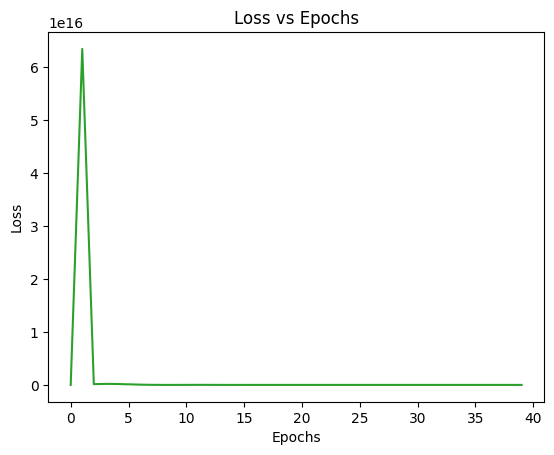

In [14]:
# Loss vs Epochs
plt.figure()
plt.plot(hist_sgd.history['loss'])
plt.plot(hist_mom.history['loss'])
plt.plot(hist_nag.history['loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [15]:
# Loss landscape projection
model=build_model()
initial=np.concatenate([w.flatten() for w in model.get_weights()])

dir1=np.random.randn(initial.shape[0]); dir1/=np.linalg.norm(dir1)
dir2=np.random.randn(initial.shape[0]); dir2/=np.linalg.norm(dir2)

alpha=np.linspace(-1,1,25)
beta=np.linspace(-1,1,25)
A,B=np.meshgrid(alpha,beta)
Z=np.zeros_like(A)

shapes=[w.shape for w in model.get_weights()]

def set_weights(vec):
    idx=0; new=[]
    for s in shapes:
        size=np.prod(s)
        new.append(vec[idx:idx+size].reshape(s))
        idx+=size
    model.set_weights(new)

model.compile(optimizer='sgd',loss='mse')

for i in range(len(alpha)):
    for j in range(len(beta)):
        vec=initial+alpha[i]*dir1+beta[j]*dir2
        set_weights(vec)
        Z[i,j]=model.evaluate(X_train,y_train,verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


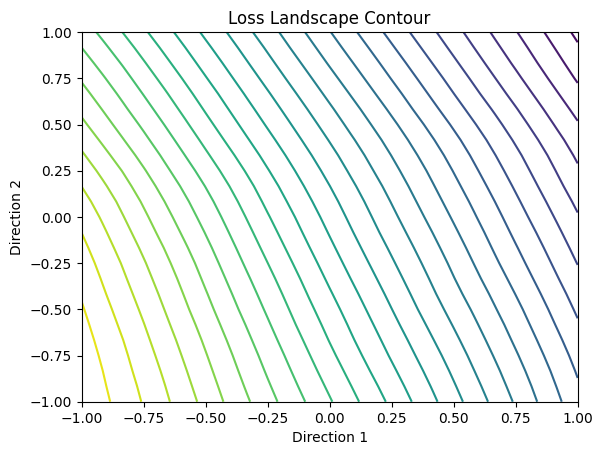

In [16]:
# Contour
plt.figure()
plt.contour(A,B,Z,levels=30)
plt.title('Loss Landscape Contour')
plt.xlabel('Direction 1')
plt.ylabel('Direction 2')
plt.show()

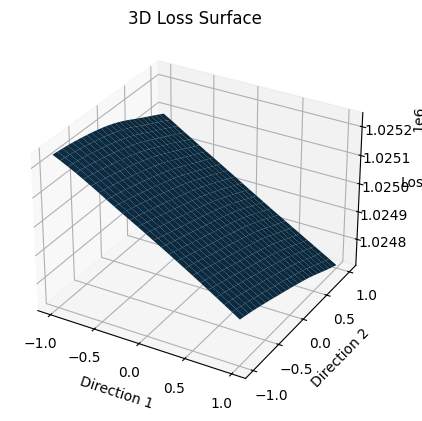

In [17]:
# 3D surface
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(A,B,Z)
ax.set_title('3D Loss Surface')
ax.set_xlabel('Direction 1')
ax.set_ylabel('Direction 2')
ax.set_zlabel('Loss')
plt.show()

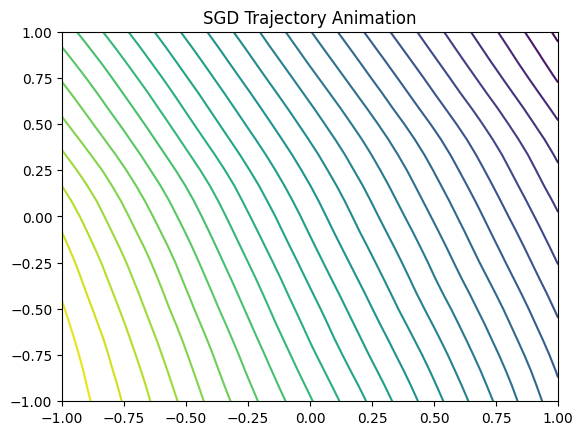

In [18]:
# GIF of SGD trajectory
proj1=[]; proj2=[]
for w in weights_sgd:
    proj1.append(np.dot(w-initial,dir1))
    proj2.append(np.dot(w-initial,dir2))

fig,ax=plt.subplots()
ax.contour(A,B,Z,levels=30)
line,=ax.plot([],[],marker='o')
ax.set_title('SGD Trajectory Animation')

def update(frame):
    line.set_data(proj1[:frame],proj2[:frame])
    return line,

ani=FuncAnimation(fig,update,frames=len(proj1),interval=200)
ani.save('optimizer_trajectory.gif',writer='pillow',fps=5)
plt.show()